In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Read in the dataset
train_df = pd.read_csv('../Modified Datasets/data_missing_clean_and_pruned.csv')
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.0,22.732803,0,2,1,180.3,4,1,0,2,...,228.0,218.571429,0,0,0,0,0,0,0,1
1,77.0,27.421875,0,2,0,160.0,4,1,0,5,...,51.0,51.000000,0,0,0,0,0,0,0,1
2,25.0,31.952749,0,2,0,172.7,3,0,0,5,...,228.0,218.571429,0,0,0,0,0,0,0,0
3,81.0,22.635548,1,2,0,165.1,8,2,0,2,...,337.0,337.000000,0,0,0,0,0,0,0,0
4,19.0,27.562370,0,2,1,188.0,3,0,0,5,...,228.0,218.571429,0,0,0,0,0,0,0,0


In [3]:
X = train_df.drop(['diabetes_mellitus'], axis=1)
y = train_df['diabetes_mellitus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify=y)

In [4]:
model_results = []

In [5]:
def calculate_scores(model_name, y_test, y_pred, score):
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return {
        "model": model_name,
        "roc_auc_score": score,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

#### Logistic Regression

In [6]:
ridge_classifier = RidgeClassifier(alpha=0.2, fit_intercept=True, solver='svd')
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)
score = roc_auc_score(y_test, ridge_classifier._predict_proba_lr(X_test)[:, 1])

In [7]:
ridge_classifier_result = calculate_scores("Ridge Classifier", y_test, y_pred, score)
model_results.append(ridge_classifier_result)

#### Decision Trees


In [8]:
# decision_tree_classifier = DecisionTreeClassifier(random_state=42)
# path = decision_tree_classifier.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas = path.ccp_alphas

In [10]:
# len(ccp_alphas)

In [ ]:
# clfs = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=12, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)

In [ ]:
# train_scores = [clf.score(X_train, y_train) for clf in clfs]
# valid_scores = [clf.score(X_test, y_test) for clf in clfs]

In [ ]:
# plt.figure(figsize = (10,8))
# plt.plot(ccp_alphas, train_scores,marker='o', label="training",
#         drawstyle="steps-post")
# plt.plot(ccp_alphas, valid_scores, marker='o', label="validation",
#         drawstyle="steps-post")
# plt.xlabel("alpha")
# plt.ylabel("Accuracy")
# plt.title("Accuracy vs alpha")
# plt.legend()
# rounded_ccp = [ round(elem, 2) for elem in ccp_alphas ]
# locs, labels = plt.xticks()
# plt.xticks(ccp_alphas, rounded_ccp, rotation = 45, fontsize = 8)
# plt.yticks(np.arange(0.3,1,0.05), fontsize = 12)
# plt.show()

#### XGBoost

In [8]:
def model_fit(alg, X_train, y_train, X_test, y_test, use_train_cv=True, cv_folds=5, early_stopping=50):
    if use_train_cv:
        xgb_params = alg.get_xgb_params()
        
        xg_train = xgb.DMatrix(X_train, label=y_train)
        cv_result = xgb.cv(xgb_params, xg_train, num_boost_round=alg.get_params()['n_estimators'],
                            metrics='auc', early_stopping_rounds=early_stopping)
        alg.set_params(n_estimators=cv_result.shape[0])

    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')

    # Predict training set
    train_predictions = alg.predict(X_train)
    train_pred_prob = alg.predict_proba(X_train)[:, 1]

    # Print model report
    print("Accuracy : %.4g" % accuracy_score(y_train, train_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, train_pred_prob))
    print("AUC Score (Test): %f" % roc_auc_score(y_test, alg.predict_proba(X_test)[:, 1]))

    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)

    plt.figure(figsize=(30, 12))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy : 0.876
AUC Score (Train): 0.919869


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


AUC Score (Test): 0.853815


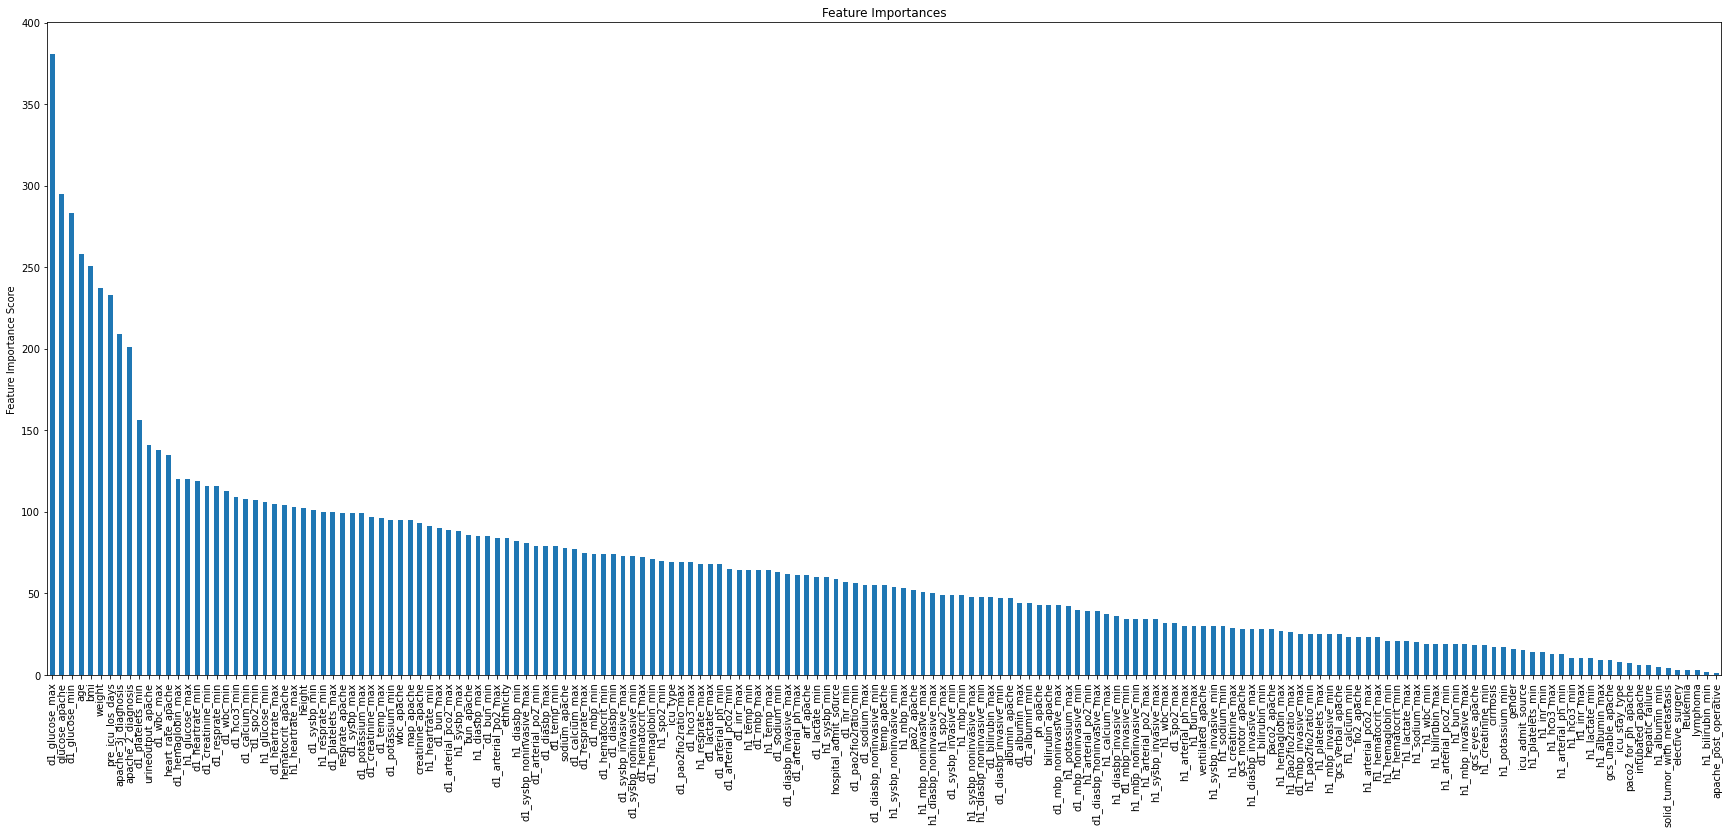

In [57]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

model_fit(xgb1, X_train, y_train, X_test, y_test)

In [ ]:
test_params_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

grid_search_1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid = test_params_1, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_1.fit(X_train, y_train)

# grid_search_1.grid_scores_, grid_search_1.best_params_, grid_search_1.best_score_

In [13]:
grid_search_1.best_params_, grid_search_1.best_score_

({'max_depth': 7, 'min_child_weight': 5}, 0.8536374861761346)

In [18]:
test_params_2 = {
 'max_depth':[6, 7, 8],
 'min_child_weight':[4, 5, 6]
}

grid_search_2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid=test_params_2, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_2.fit(X_train, y_train)

grid_search_2.best_params_, grid_search_2.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:04:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 7, 'min_child_weight': 5}, 0.8536374861761346)

#### LightGBM